# MP1: K-Nearest Neighbors

We will be using `numpy`, `pandas`, `seaborn`, `matplotlib`, `PIL`, and the standard Python libraries for this earlier part of the notebook.

### Importing Libraries

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import PIL

from scipy.stats import mode
from statistics import mode

### Loading the dataset

The MNIST dataset consists of 70,000 labeled images of handwritten digits, each of size 28 pixels by 28 pixels. 



The dataset is in the CSV file, `mnist.csv`. The CSV file has ~70,000 rows and 785 columns. The train and test images in .CSV format can also be downloaded individually from [here](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv).

- Each row represents one image of a handwritten digit. Note that the header row contains the names of the columns.

- The first column gives the label (a number from 0 to 9). The next 784 columns give the value of each pixel. There are 784 pixels in each image corresponding to an image size of 28 by 28.

For faster prototyping, 20% of the entire dataset will be sampled

In [152]:
# Loading the dataset
data = pd.read_csv('mnist.csv', dtype = str, low_memory = False)

# Printing the shapes of the loaded data
numpy_data = data.to_numpy() # converting to numpy array
numpy_data = numpy_data[1:, :].astype(float)
print("Shape of the Data now stored in a Numpy Array: ", numpy_data.shape) # printing the shape of the data

Shape of the Data now stored in a Numpy Array:  (70000, 785)


In [153]:
# Randomly sampling 20% of the data to reduce computation time. Note that this is not a train-test split
rows_sampled = int(0.2 * numpy_data.shape[0])
index = np.random.choice(numpy_data.shape[0], rows_sampled, replace = False)
sampled_data = numpy_data[index]
print("Shape of the Sampled Data:", sampled_data.shape) # printing shape of the sampled data

Shape of the Sampled Data: (14000, 785)


### Displaying some Images

Reshaping these 784 values for each image, into a `28x28` array, then use either `matplotlib` or `PIL` to display the image.

In [154]:
# Implementing a display_image function
def display_image(arr):
    '''
    Takes a 2D numpy array, reshapes to a 28x28 array and displays the image
    '''
    image = arr.reshape(28, 28)
    plt.axis('off')
    plt.imshow(image, cmap = 'grey')
    plt.show()

Image # 3756


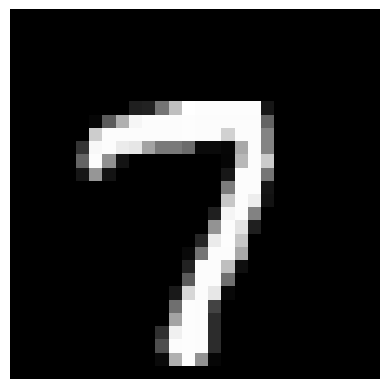

Image # 13327


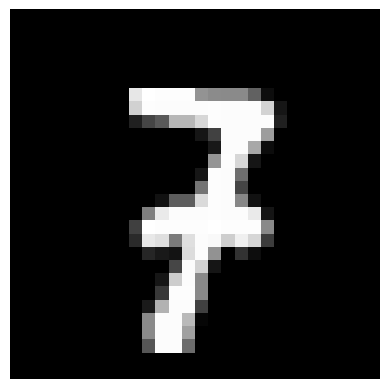

Image # 8572


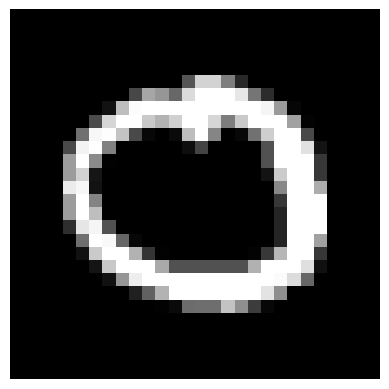

Image # 7830


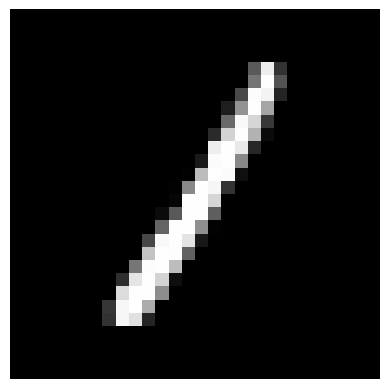

Image # 10398


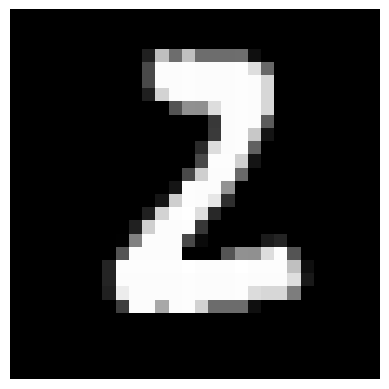

In [155]:
# Randomly picks and displays 5 images from the sampled dataset
rows = np.random.choice(len(sampled_data), size = 5, replace = False)

for i in rows:
    image_data = sampled_data[i, :]
    image_data = image_data[1 :]
    image_data = image_data
    print('Image #', i)
    display_image(image_data)

### Train-Test Split

With the data loaded, we will setup a proper Cross Validation scheme for the modeling experiments, before we actually start building the model.

The dataset is to be divided into training and test sets (an 85-15 split). More precisely, the first 11900 images for the training set and the last 2100 for the test set.

In [156]:
# Creating an 85-15 train-test split
train_data_size = 11900
data_train = sampled_data[:train_data_size , :]
data_test = sampled_data[train_data_size: , :]

# Printing the shapes of both arrays
print("Shape of Train Data:", data_train.shape)
print("Shape of Test Data:", data_test.shape)

Shape of Train Data: (11900, 785)
Shape of Test Data: (2100, 785)


In [157]:
# Split the train and test into images and their true labels
features_train = data_train[:, 1:]
labels_train = data_train[:, 0] 
features_test = data_test[:, 1:]
labels_test = data_test[:, 0]

# Printing the shapes of these newly created arrays
print("Shape of features_train:", features_train.shape)
print("Shape of labels_train:", labels_train.shape)
print("Shape of features_test:", features_test.shape)
print("Shape of labels_test:", labels_test.shape)

Shape of features_train: (11900, 784)
Shape of labels_train: (11900,)
Shape of features_test: (2100, 784)
Shape of labels_test: (2100,)


### Implementing the K-NN Classifier

Here we are going to implement the KNN classifier. The general idea and steps to follow along are given below: 

1. For a single test data point, we will find its distance from all the other training points.

2. Sort the calculated distances in ascending order based on the distance values.

3. Choose `k` training samples with minimum distances from the test data point (nearest neighbours)

4. Return the *most frequent* class of these samples. 



**Note:** The function created below will work with both the `Euclidean` distance as well as `Manhattan` distance. The distance metric will be passed as a parameter in the KNN classifier function. The function also lets one specify the value of the hyperparameter `k`.

For values of `k` where a tie occurs, we will break the tie by backing off to the `k-1` value. In case there is still a tie, continue decreasing `k` until there is a clear winner.

#### Distance functions:
I will be creating seperate functions for the distance functions. Formulas used for both `Euclidean` distance and `Manhattan` distance are given below.

$$
d_{\text{Euclidean}}(\vec{p},\vec{q}) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + (p_3 - q_3)^2 + ... + (p_n - q_n)^2}
$$

$$
d_{\text{Manhattan}}(\vec{p},\vec{q}) = |(p_1 - q_1)| + |(p_2 - q_2)| + |(p_3 - q_3)| + ... + |(p_n - q_n)|
$$

In [158]:
# Implementing the Euclidean distance function
def euclidean_distance(vector1, vector2):
    euc_distance = np.sqrt(np.sum(np.square(vector1 - vector2), axis = 1)) 
    return euc_distance

# Implementing Manhattan distance function
def manhattan_distance(vector1, vector2):
    manh_distance = np.sum(np.abs((vector1 - vector2)),  axis = 1)
    return manh_distance

#### K-NN Classifier methods

The following method functions under the `kNearestNeighbours` class are briefed below:

1. `fit` : Fits the training data (images and their labels) to the model

2. `get_neighbours` : Returns `k` nearest neighbors of a particular data point

3. `predict` : Predicts the label for the data point in question

In [159]:
class kNearestNeighbours:
  def __init__(self, num_neighbors): 
    """
    n_neighbours: value of k
    X: array of training data points
    y: array of gold labels for training points
    """
    
    self.n_neighbors = num_neighbors
    self.X = None
    self.y = None
  
  def fit(self, X_train, y_train):
    '''
    Fitting the training data to the model
    '''
    
    self.X = X_train 
    self.y = y_train

  def get_neighbors(self, x , distanceFunction):
    """
    Returning the k nearest neighbours of the input data point x.
    """
    
    distance_from_x = distanceFunction(x, self.X) # finds the distance between x and the current point in training data
    nearest_neighbour_indices = np.argsort(distance_from_x)[:self.n_neighbors] # sorts and then finds and returns the k nearest neighbors of point x
    return nearest_neighbour_indices
  
  def predict(self, X_test, distanceFunction):
    """
    Returns an array of predicted labels for all points in the X_test array

    Parameters
    ----------
    X_test : array
        The test data

    distanceFunction : function
        The distance function to be used
    """
    labels_predicted = []

    for i in range(X_test.shape[0]):
        neighbors_indexes = self.get_neighbors(X_test[i, :], distanceFunction)
        labels_of_neighbors = self.y[neighbors_indexes].astype(int)
        most_common_label = np.bincount(labels_of_neighbors).argmax()
        labels_predicted.append(most_common_label)
        
    return np.array(labels_predicted)

#### Evaluation phase

- I will be implementing an `evaluation` function that computes the Confusion Matrix, Accuracy, and Macro-Average F1 score of the classifier altogether. 
- This function will take as input both the predicted labels and the true labels.
- The confusion matrix will be made as a heatmap annotated with the data values.

In [160]:
def calculate_accuracy(predicted_labels, true_labels):
    '''
    Returns the accuracy of the predictions against the true labels
    
    Parameters
    ----------
    predicted_labels : array

    true_labels : array
    """
    '''
    correct_predictions = np.sum(predicted_labels == true_labels)
    total_predictions = len(true_labels) # I chose true_labels here because there can be instances where the model does not predict anything
    return (correct_predictions/total_predictions).astype(float)

In [161]:
def make_confusion_matrix(predicted_labels, true_labels):
    '''
    Computes the confusion matrix as a 2D array
    '''
    num_classes = len(np.unique(true_labels))
    
    confusion_matrix = np.zeros((num_classes , num_classes))

    num_labels = len(predicted_labels)

    for i in range(num_labels):
        predicted = int(predicted_labels[i])
        gold = true_labels[i].astype(int)
        if 0 <= predicted < num_classes and 0 <= gold < num_classes:
            confusion_matrix[predicted][gold] = confusion_matrix[predicted][gold] + 1
    return confusion_matrix

In [162]:
def make_heat_map(data, title):
    '''
    Creates a heatmap from the 2D matrix input
    '''
    plt.figure(figsize=(9, 6))
    sns.heatmap(data, annot = True, cmap = sns.cubehelix_palette(as_cmap = True), linewidths = 1, fmt = '.1f')
    plt.title(title)
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.show()

In [163]:
def calculate_precision(confusion_matrix, class_label):
    '''
    Calculates the precision from a provided confusion matrix
    '''
    true_positives = confusion_matrix[class_label][class_label]
    false_positives = sum(confusion_matrix[class_label][i] for i in range(len(confusion_matrix)) if i != class_label)
    precision = (true_positives/(true_positives + false_positives))
    return precision

In [164]:
def calculate_recall(confusion_matrix, class_label):
    '''
    Calculates the recall from a provided confusion matrix
    '''
    # recall = true positives / (true positives + false negatives)
    true_positives = confusion_matrix[class_label][class_label]
    false_negatives = sum(confusion_matrix[i][class_label] for i in range(len(confusion_matrix)) if i != class_label)
    recall = (true_positives/(true_positives + false_negatives))
    return recall

In [165]:

def calculate_f1_score(precision, recall):
    '''
    Calculates the F1 score from a provided precision and recall
    ''' 
    f1_score = 2 * ((precision * recall)/(precision + recall))
    return f1_score

In [166]:
def macro_average_f1(confusion_matrix):
    '''
    Calculates the macro-average F1 score from a provided confusion matrix, over all classes
    '''
    f1_scores = []
    for i in range(len(confusion_matrix)):
        tp = confusion_matrix[i][i]
        
        row_elements = confusion_matrix[i, :] # iterating over all column elements in i'th row
        fp = sum(row_elements) - tp # subtracting tp from total to get fp

        column_elements = confusion_matrix[:, i] # iterating over all row elements in i'th col
        fn = sum(column_elements) - tp # subtracting tp from total to get fn

        precision = tp/(tp + fp)
        recall = tp/(tp + fn)  
        f1_scores.append(calculate_f1_score(precision, recall)) # reusing the function made earlier
    
    macro_averaged_f1_score = sum(f1_scores)/len(f1_scores)
    return macro_averaged_f1_score

In [167]:
def evaluation(predicted_labels,true_labels):
    '''
    Computes the Confusion Matrix, Accuracy and Macro-average F1 score from the predictions and true labels
    '''
    confusion_matrix = make_confusion_matrix(predicted_labels, true_labels)
    accuracy = calculate_accuracy(predicted_labels, true_labels)
    macroF1= macro_average_f1(confusion_matrix)
    return confusion_matrix, accuracy, macroF1

#### `K-fold` Cross Validation


Now with the basics done, we move to the next step: `K-fold` Cross Validation. This is a more robust way of evaluating the model since it uses all the data for training and testing (effectively giving `k` chances to verify the generalizability of the model).

In Cross Validation, the dataset gets divided into `k` parts. `k-1` parts will be used for training and `1` part will be used for validation. This process will be repeated `k` times, each time using a different part for validation, eventually averaging the results of each fold to get the final result. 

The function returns **predictions** for the **entire training data** (size of list/array be equal to the size of the dataset). This is the result of appending the predicted labels for each validation-train split into a single list/array. Also, it ensures that the order of the predicted labels matches the order of the training dataset, so that they may directly be passed to the `evaluation` function together with the actual labels.

In [168]:
def k_fold_split(k, cv_no, data):
    '''
    Returns the training and validation sets for a given value of k

    Parameters
    ----------
    k : int
        The value of k
    cv_no : int
        The current fold number
    data : array
        The dataset
    '''
    width_of_fold = int(len(data) / k) # to ensure that we get an integer for the width of each fold
    starting_index_v = (cv_no - 1) * width_of_fold # starting index for the validation set chosen
    ending_index_v = starting_index_v + width_of_fold if cv_no < k else len(data) # ending index handling the case when we get last fold as our validation set
    validation_set = data[starting_index_v : ending_index_v] # defining the validation set in the data
    training_set = 0

    if cv_no == 1:
        training_set = data[ending_index_v : ]
    elif cv_no == k:
        training_set = data[ : starting_index_v]
    else:
        training_set = np.concatenate((data[0 : starting_index_v], data[ending_index_v : ]))
    return training_set, validation_set

In [169]:
def k_fold_cross_validation(num_folds, k, dataset, distanceFunction):
    """
    Returns the predictions for all the data points in the dataset using k-fold cross validation

    num_folds: int
      Number of folds
    k: int
      Number of neighbours to consider (hyperparameter)
    dataset: array
      The dataset to be used (note that this should be the training set which has 11900 samples)
    """
    pred_lables = np.array([])
    knn = kNearestNeighbours(k)
    for i in range(num_folds):
      train_d,validation_d = k_fold_split(num_folds, i+1, dataset)
      knn.fit(train_d[:, 1:], train_d[:, 0])
      pred_lables = np.concatenate((pred_lables, knn.predict(validation_d[:, 1:], distanceFunction)))
    return pred_lables.astype(int)

Running the cross-validation function on the training data using `5-fold cross validation` for the values of `k = [1, 2, 3, 4, 5]`. 

Doing this for both the Euclidean distance and the Manhattan distance for each value of `k`. Also running the evaluation metrics for each value of `k` (for both distance functions) and printing out the classification accuracy and F1 score for each.

**[Number of folds = 5] and [k = 1]**

K-Fold Cross Validation for [k = 1] - [Manhattan Distance] - [5 folds]
 
Accuracy [Manhattan]: 0.9368067226890756
 
Macro Average F1 [Manhattan] 0.9358935135103044
 
Confusion Matrix [Manhattan]
 
[[1.213e+03 0.000e+00 1.200e+01 3.000e+00 2.000e+00 4.000e+00 5.000e+00
  1.000e+00 1.100e+01 7.000e+00]
 [0.000e+00 1.322e+03 2.700e+01 3.000e+00 1.600e+01 7.000e+00 5.000e+00
  2.200e+01 2.500e+01 2.000e+00]
 [3.000e+00 1.000e+00 1.063e+03 7.000e+00 0.000e+00 1.000e+00 1.000e+00
  4.000e+00 8.000e+00 2.000e+00]
 [0.000e+00 0.000e+00 8.000e+00 1.076e+03 0.000e+00 2.400e+01 0.000e+00
  0.000e+00 2.900e+01 1.300e+01]
 [0.000e+00 3.000e+00 6.000e+00 0.000e+00 1.046e+03 7.000e+00 2.000e+00
  5.000e+00 5.000e+00 4.100e+01]
 [3.000e+00 0.000e+00 2.000e+00 3.800e+01 0.000e+00 9.870e+02 1.300e+01
  0.000e+00 5.400e+01 2.000e+00]
 [7.000e+00 2.000e+00 5.000e+00 3.000e+00 3.000e+00 1.700e+01 1.175e+03
  0.000e+00 5.000e+00 2.000e+00]
 [2.000e+00 3.000e+00 3.000e+01 1.300e+01 8.000e+00 4.000e+00 0.000e

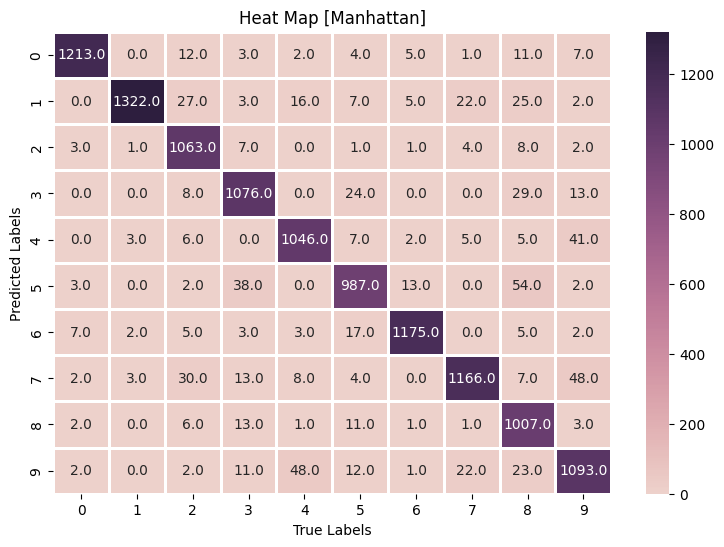

 
K-Fold Cross Validation for [k = 1] - [Euclidean Distance] - [5 folds]
 
Accuracy [Euclidean]: 0.9487394957983193
 
Macro Average F1 [Euclidean] 0.9479975840020869
 
Confusion Matrix [Euclidean]
 
[[1.216e+03 1.000e+00 7.000e+00 3.000e+00 1.000e+00 5.000e+00 4.000e+00
  1.000e+00 9.000e+00 7.000e+00]
 [0.000e+00 1.321e+03 1.500e+01 3.000e+00 1.300e+01 1.000e+00 4.000e+00
  1.600e+01 1.700e+01 1.000e+00]
 [1.000e+00 1.000e+00 1.085e+03 8.000e+00 0.000e+00 2.000e+00 1.000e+00
  6.000e+00 7.000e+00 1.000e+00]
 [1.000e+00 1.000e+00 8.000e+00 1.088e+03 0.000e+00 2.300e+01 0.000e+00
  0.000e+00 2.600e+01 9.000e+00]
 [0.000e+00 3.000e+00 5.000e+00 0.000e+00 1.063e+03 5.000e+00 1.000e+00
  4.000e+00 2.000e+00 2.700e+01]
 [2.000e+00 0.000e+00 0.000e+00 2.900e+01 0.000e+00 9.940e+02 1.300e+01
  0.000e+00 3.800e+01 2.000e+00]
 [7.000e+00 1.000e+00 5.000e+00 3.000e+00 2.000e+00 1.900e+01 1.178e+03
  0.000e+00 4.000e+00 2.000e+00]
 [3.000e+00 3.000e+00 2.500e+01 1.100e+01 5.000e+00 4.000e+00 0.00

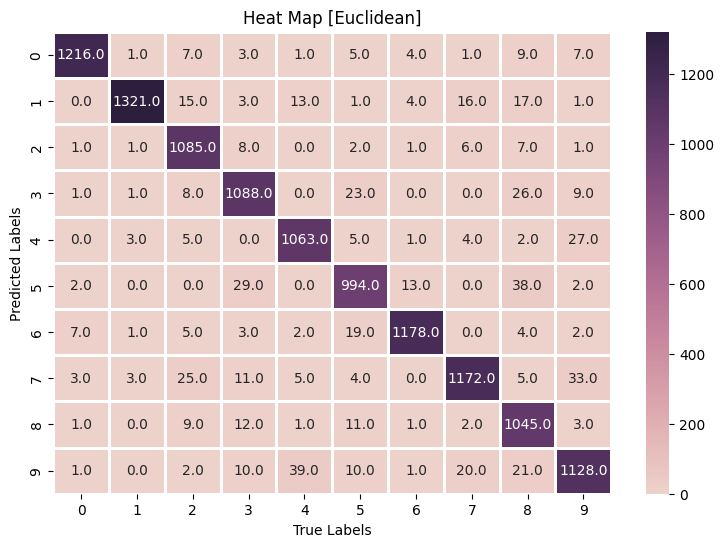

In [170]:
k = 1
num_of_folds = 5

print('K-Fold Cross Validation for [k = 1] - [Manhattan Distance] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, manhattan_distance)
confusion_matrix_1, accuracy_1, macro_avg_f1_1 = evaluation(predicted_labels, labels_train)
print(" ")
print('Accuracy [Manhattan]:', accuracy_1)
print(" ")
print('Macro Average F1 [Manhattan]', macro_avg_f1_1)
print(" ")
print('Confusion Matrix [Manhattan]') 
print(" ")
print(confusion_matrix_1)
make_heat_map(confusion_matrix_1,'Heat Map [Manhattan]')
print(" ")
print('K-Fold Cross Validation for [k = 1] - [Euclidean Distance] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, euclidean_distance)
confusion_matrix_2, accuracy_2, macro_avg_f1_2 = evaluation(predicted_labels, labels_train)
print(" ")
print('Accuracy [Euclidean]:', accuracy_2)
print(" ")
print('Macro Average F1 [Euclidean]', macro_avg_f1_2)
print(" ")
print('Confusion Matrix [Euclidean]')
print(" ")
print(confusion_matrix_2)
make_heat_map(confusion_matrix_2,'Heat Map [Euclidean]')

**[Number of folds = 5] and [k = 2]**

K-Fold Cross Validation for [k = 2] - [Manhattan Distance] - [5 folds]
 
Accuracy [Manhattan]: 0.925798319327731
 
Macro Average F1 [Manhattan] 0.9245968651839845
 
Confusion Matrix [Manhattan]
 
[[1.219e+03 0.000e+00 2.700e+01 7.000e+00 2.000e+00 1.000e+01 1.800e+01
  1.000e+00 1.600e+01 1.100e+01]
 [0.000e+00 1.325e+03 3.900e+01 1.000e+01 2.500e+01 1.500e+01 7.000e+00
  2.900e+01 4.500e+01 1.100e+01]
 [3.000e+00 1.000e+00 1.065e+03 1.800e+01 1.000e+00 2.000e+00 0.000e+00
  9.000e+00 2.000e+01 1.000e+00]
 [1.000e+00 0.000e+00 4.000e+00 1.105e+03 0.000e+00 5.700e+01 1.000e+00
  2.000e+00 5.100e+01 1.800e+01]
 [1.000e+00 1.000e+00 4.000e+00 0.000e+00 1.075e+03 9.000e+00 3.000e+00
  9.000e+00 8.000e+00 7.500e+01]
 [1.000e+00 0.000e+00 0.000e+00 1.300e+01 0.000e+00 9.670e+02 1.600e+01
  0.000e+00 6.900e+01 4.000e+00]
 [5.000e+00 1.000e+00 1.000e+00 1.000e+00 2.000e+00 8.000e+00 1.157e+03
  1.000e+00 8.000e+00 2.000e+00]
 [1.000e+00 3.000e+00 1.900e+01 8.000e+00 3.000e+00 1.000e+00 1.000e+

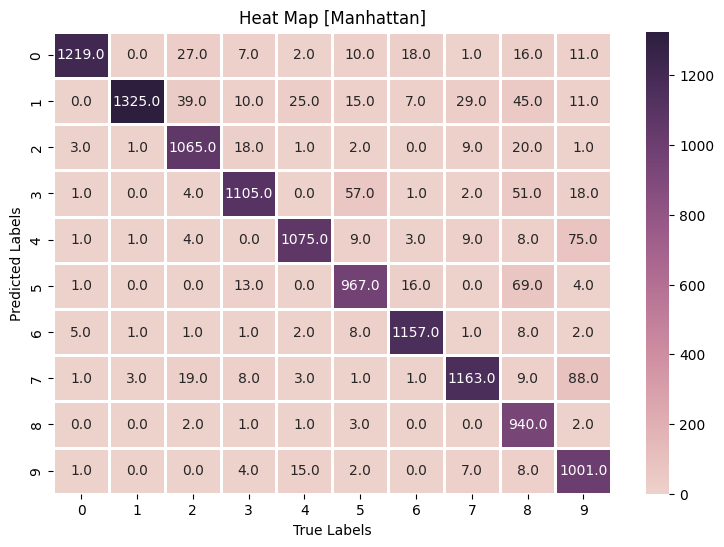

 
K-Fold Cross Validation for [k = 2] - [Euclidean] - [5 folds]
 
Accuracy [Euclidean]: 0.9384033613445378
 
Macro Average F1 [Euclidean] 0.937421671018104
 
Confusion Matrix [Euclidean]
 
[[1.220e+03 1.000e+00 2.100e+01 7.000e+00 2.000e+00 1.000e+01 1.500e+01
  4.000e+00 1.500e+01 1.000e+01]
 [0.000e+00 1.325e+03 2.400e+01 7.000e+00 1.800e+01 9.000e+00 6.000e+00
  2.700e+01 2.600e+01 5.000e+00]
 [4.000e+00 1.000e+00 1.090e+03 1.500e+01 0.000e+00 3.000e+00 1.000e+00
  8.000e+00 1.700e+01 1.000e+00]
 [1.000e+00 0.000e+00 4.000e+00 1.112e+03 0.000e+00 5.000e+01 0.000e+00
  2.000e+00 4.500e+01 1.600e+01]
 [0.000e+00 0.000e+00 4.000e+00 1.000e+00 1.084e+03 9.000e+00 3.000e+00
  1.000e+01 6.000e+00 5.900e+01]
 [1.000e+00 0.000e+00 0.000e+00 1.200e+01 0.000e+00 9.800e+02 1.900e+01
  0.000e+00 5.800e+01 4.000e+00]
 [4.000e+00 1.000e+00 2.000e+00 1.000e+00 3.000e+00 5.000e+00 1.159e+03
  1.000e+00 8.000e+00 2.000e+00]
 [1.000e+00 3.000e+00 1.500e+01 6.000e+00 3.000e+00 2.000e+00 0.000e+00
  1.

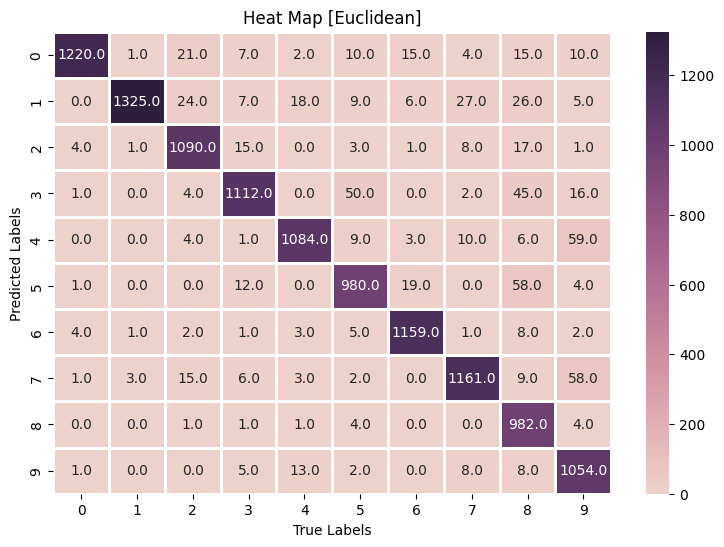

In [171]:
k = 2
num_of_folds = 5

print('K-Fold Cross Validation for [k = 2] - [Manhattan Distance] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, manhattan_distance)
confusion_matrix_12, accuracy_12, macro_avg_f1_12 = evaluation(predicted_labels, labels_train)
print(" ")
print('Accuracy [Manhattan]:', accuracy_12)
print(" ")
print('Macro Average F1 [Manhattan]', macro_avg_f1_12)
print(" ")
print('Confusion Matrix [Manhattan]') 
print(" ")
print(confusion_matrix_12)
make_heat_map(confusion_matrix_12,'Heat Map [Manhattan]')
print(" ")
print('K-Fold Cross Validation for [k = 2] - [Euclidean] - [5 folds]')
print(" ")
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, euclidean_distance)
confusion_matrix_22, accuracy_22, macro_avg_f1_22 = evaluation(predicted_labels, labels_train)
print('Accuracy [Euclidean]:', accuracy_22)
print(" ")
print('Macro Average F1 [Euclidean]', macro_avg_f1_22)
print(" ")
print('Confusion Matrix [Euclidean]')
print(" ") 
print(confusion_matrix_22)
make_heat_map(confusion_matrix_22,'Heat Map [Euclidean]')

**[Number of folds = 5] and [k = 3]**

K-Fold Cross Validation for [k = 3] - [Manhattan Distance] - [5 folds]
 
Accuracy [Manhattan]: 0.9385714285714286
 
Macro Average F1 [Manhattan] 0.937979903678654
 
Confusion Matrix [Manhattan]
 
[[1.215e+03 1.000e+00 1.800e+01 7.000e+00 0.000e+00 1.100e+01 9.000e+00
  1.000e+00 1.400e+01 1.100e+01]
 [1.000e+00 1.323e+03 3.600e+01 1.000e+01 2.200e+01 1.200e+01 5.000e+00
  2.500e+01 3.800e+01 1.000e+01]
 [5.000e+00 2.000e+00 1.060e+03 1.200e+01 0.000e+00 2.000e+00 0.000e+00
  4.000e+00 1.400e+01 3.000e+00]
 [0.000e+00 1.000e+00 4.000e+00 1.084e+03 0.000e+00 2.400e+01 0.000e+00
  0.000e+00 4.200e+01 1.300e+01]
 [0.000e+00 0.000e+00 2.000e+00 0.000e+00 1.050e+03 9.000e+00 1.000e+00
  6.000e+00 6.000e+00 2.700e+01]
 [2.000e+00 0.000e+00 1.000e+00 2.700e+01 0.000e+00 9.870e+02 1.100e+01
  0.000e+00 3.600e+01 1.000e+00]
 [7.000e+00 1.000e+00 5.000e+00 1.000e+00 6.000e+00 1.500e+01 1.177e+03
  1.000e+00 6.000e+00 1.000e+00]
 [1.000e+00 3.000e+00 3.100e+01 1.200e+01 3.000e+00 3.000e+00 0.000e+

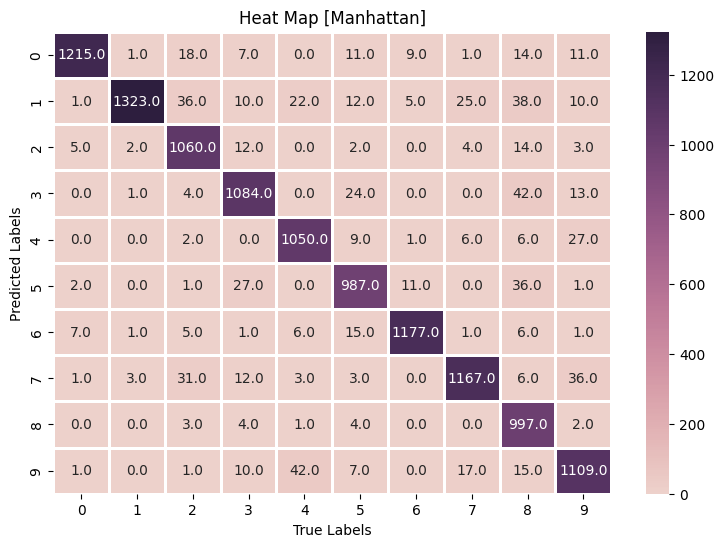

 
K-Fold Cross Validation for [k = 3] - [Euclidean] - [5 folds]
 
Accuracy [Euclidean]: 0.9467226890756303
 
Macro Average F1 [Euclidean] 0.9461358033984828
 
Confusion Matrix [Euclidean]
 
[[1.215e+03 1.000e+00 1.700e+01 4.000e+00 0.000e+00 1.100e+01 1.000e+01
  2.000e+00 1.100e+01 8.000e+00]
 [0.000e+00 1.323e+03 2.100e+01 8.000e+00 1.500e+01 7.000e+00 4.000e+00
  2.200e+01 2.400e+01 6.000e+00]
 [5.000e+00 2.000e+00 1.076e+03 1.100e+01 0.000e+00 3.000e+00 1.000e+00
  4.000e+00 1.000e+01 3.000e+00]
 [1.000e+00 1.000e+00 5.000e+00 1.087e+03 0.000e+00 2.500e+01 0.000e+00
  0.000e+00 3.300e+01 1.200e+01]
 [0.000e+00 0.000e+00 7.000e+00 1.000e+00 1.057e+03 6.000e+00 1.000e+00
  3.000e+00 4.000e+00 1.700e+01]
 [2.000e+00 0.000e+00 0.000e+00 2.600e+01 0.000e+00 9.940e+02 1.000e+01
  0.000e+00 3.300e+01 1.000e+00]
 [7.000e+00 1.000e+00 5.000e+00 2.000e+00 4.000e+00 1.300e+01 1.177e+03
  1.000e+00 4.000e+00 1.000e+00]
 [1.000e+00 3.000e+00 2.300e+01 1.300e+01 3.000e+00 1.000e+00 0.000e+00
  1

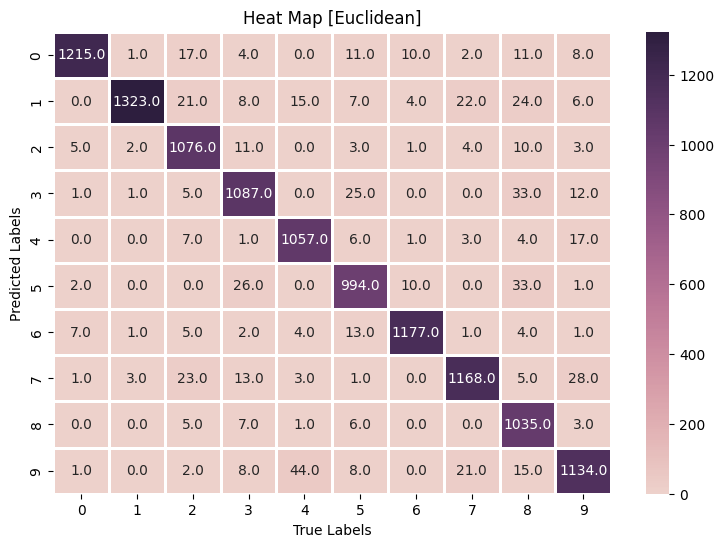

In [172]:
k = 3
num_of_folds = 5

print('K-Fold Cross Validation for [k = 3] - [Manhattan Distance] - [5 folds]')
print(" ")
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, manhattan_distance)
confusion_matrix_13, accuracy_13, macro_avg_f1_13 = evaluation(predicted_labels, labels_train)
print('Accuracy [Manhattan]:', accuracy_13)
print(" ")
print('Macro Average F1 [Manhattan]', macro_avg_f1_13)
print(" ")
print('Confusion Matrix [Manhattan]')
print(" ")
print(confusion_matrix_13)
make_heat_map(confusion_matrix_13,'Heat Map [Manhattan]')
print(" ")
print('K-Fold Cross Validation for [k = 3] - [Euclidean] - [5 folds]')
print(" ")
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, euclidean_distance)
confusion_matrix_23, accuracy_23, macro_avg_f1_23 = evaluation(predicted_labels, labels_train)
print('Accuracy [Euclidean]:', accuracy_23)
print(" ")
print('Macro Average F1 [Euclidean]', macro_avg_f1_23)
print(" ")
print('Confusion Matrix [Euclidean]') 
print(" ")
print(confusion_matrix_23)
make_heat_map(confusion_matrix_23,'Heat Map [Euclidean]')

**[Number of folds = 5] and [k = 4]**

K-Fold Cross Validation for [k = 4] - [Manhattan Distance] - [5 folds]
 
Accuracy [Manhattan]: 0.9358823529411765
 
Macro Average F1 [Manhattan] 0.9352331159853279
 
Confusion Matrix [Manhattan]
[[1.218e+03 0.000e+00 1.500e+01 5.000e+00 0.000e+00 1.000e+01 1.300e+01
  1.000e+00 1.200e+01 9.000e+00]
 [1.000e+00 1.324e+03 3.900e+01 1.000e+01 2.500e+01 1.500e+01 6.000e+00
  2.700e+01 4.400e+01 7.000e+00]
 [2.000e+00 2.000e+00 1.054e+03 8.000e+00 0.000e+00 2.000e+00 0.000e+00
  6.000e+00 1.400e+01 1.000e+00]
 [0.000e+00 1.000e+00 5.000e+00 1.088e+03 0.000e+00 3.000e+01 0.000e+00
  1.000e+00 3.800e+01 1.300e+01]
 [1.000e+00 0.000e+00 3.000e+00 1.000e+00 1.065e+03 9.000e+00 1.000e+00
  1.000e+01 4.000e+00 3.900e+01]
 [2.000e+00 0.000e+00 1.000e+00 2.300e+01 0.000e+00 9.850e+02 1.100e+01
  0.000e+00 4.900e+01 1.000e+00]
 [6.000e+00 2.000e+00 6.000e+00 2.000e+00 5.000e+00 1.100e+01 1.172e+03
  0.000e+00 7.000e+00 1.000e+00]
 [2.000e+00 2.000e+00 3.100e+01 1.600e+01 4.000e+00 2.000e+00 0.000e+0

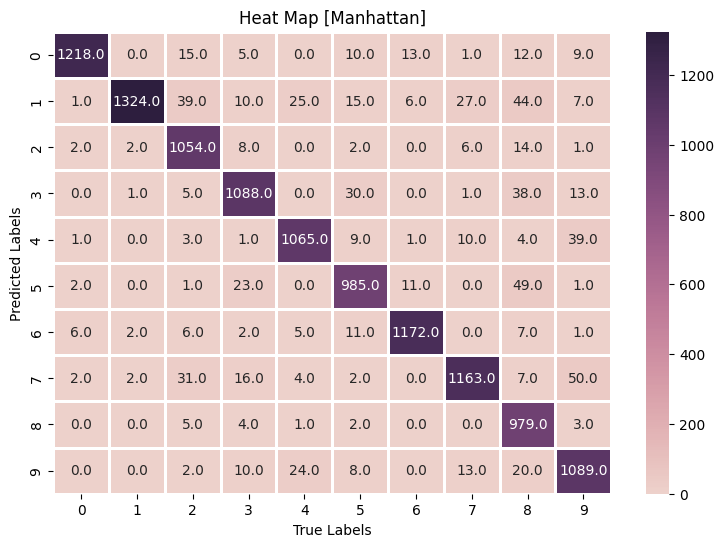

 
K-Fold Cross Validation for [k = 4] - [Euclidean] - [5 folds]
 
Accuracy [Euclidean]: 0.9466386554621848
 
Macro Average F1 [Euclidean] 0.9460557387573629
 
Confusion Matrix [Euclidean]
 
[[1.217e+03 1.000e+00 1.400e+01 4.000e+00 0.000e+00 9.000e+00 1.300e+01
  1.000e+00 1.100e+01 9.000e+00]
 [1.000e+00 1.323e+03 2.400e+01 8.000e+00 1.500e+01 1.000e+01 5.000e+00
  2.400e+01 2.500e+01 5.000e+00]
 [4.000e+00 3.000e+00 1.080e+03 1.100e+01 0.000e+00 3.000e+00 1.000e+00
  5.000e+00 7.000e+00 1.000e+00]
 [1.000e+00 1.000e+00 5.000e+00 1.100e+03 0.000e+00 3.300e+01 0.000e+00
  1.000e+00 3.700e+01 9.000e+00]
 [0.000e+00 0.000e+00 2.000e+00 1.000e+00 1.079e+03 9.000e+00 1.000e+00
  9.000e+00 2.000e+00 3.400e+01]
 [2.000e+00 0.000e+00 0.000e+00 1.500e+01 0.000e+00 9.880e+02 9.000e+00
  0.000e+00 3.900e+01 0.000e+00]
 [5.000e+00 0.000e+00 5.000e+00 2.000e+00 3.000e+00 1.100e+01 1.174e+03
  0.000e+00 6.000e+00 1.000e+00]
 [1.000e+00 3.000e+00 2.300e+01 1.200e+01 2.000e+00 1.000e+00 0.000e+00
  1

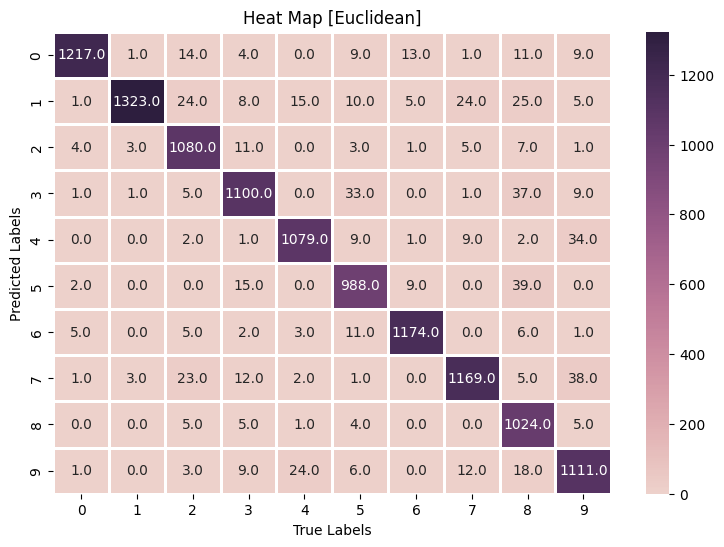

In [173]:
k = 4
num_of_folds = 5

print('K-Fold Cross Validation for [k = 4] - [Manhattan Distance] - [5 folds]')
print(" ")
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, manhattan_distance)
confusion_matrix_14, accuracy_14, macro_avg_f1_14 = evaluation(predicted_labels, labels_train)
print('Accuracy [Manhattan]:', accuracy_14)
print(" ")
print('Macro Average F1 [Manhattan]', macro_avg_f1_14)
print(" ")
print('Confusion Matrix [Manhattan]') 
print(confusion_matrix_14)
make_heat_map(confusion_matrix_14,'Heat Map [Manhattan]')
print(" ")
print('K-Fold Cross Validation for [k = 4] - [Euclidean] - [5 folds]')
print(" ")
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, euclidean_distance)
confusion_matrix_24, accuracy_24, macro_avg_f1_24 = evaluation(predicted_labels, labels_train)
print('Accuracy [Euclidean]:', accuracy_24)
print(" ")
print('Macro Average F1 [Euclidean]', macro_avg_f1_24)
print(" ")
print('Confusion Matrix [Euclidean]') 
print(" ")
print(confusion_matrix_24)
make_heat_map(confusion_matrix_24,'Heat Map [Euclidean]')

**[Number of folds = 5] and [k = 5]**

K-Fold Cross Validation for [k = 5] - [Manhattan Distance] - [5 folds]
 
Accuracy [Manhattan]: 0.9373949579831933
 
Macro Average F1 [Manhattan] 0.9368598789367034
 
Confusion Matrix [Manhattan] [[1.215e+03 0.000e+00 1.400e+01 4.000e+00 0.000e+00 9.000e+00 1.000e+01
  1.000e+00 7.000e+00 9.000e+00]
 [1.000e+00 1.325e+03 3.800e+01 1.200e+01 2.200e+01 1.300e+01 6.000e+00
  2.900e+01 4.200e+01 1.200e+01]
 [2.000e+00 2.000e+00 1.047e+03 7.000e+00 0.000e+00 2.000e+00 0.000e+00
  6.000e+00 9.000e+00 1.000e+00]
 [0.000e+00 0.000e+00 7.000e+00 1.084e+03 0.000e+00 2.400e+01 0.000e+00
  1.000e+00 4.000e+01 1.100e+01]
 [2.000e+00 0.000e+00 4.000e+00 1.000e+00 1.051e+03 9.000e+00 1.000e+00
  6.000e+00 4.000e+00 2.800e+01]
 [4.000e+00 0.000e+00 3.000e+00 2.600e+01 0.000e+00 9.880e+02 9.000e+00
  0.000e+00 4.400e+01 1.000e+00]
 [6.000e+00 2.000e+00 5.000e+00 2.000e+00 5.000e+00 1.500e+01 1.176e+03
  0.000e+00 7.000e+00 1.000e+00]
 [2.000e+00 1.000e+00 3.700e+01 1.600e+01 5.000e+00 2.000e+00 1.000e+0

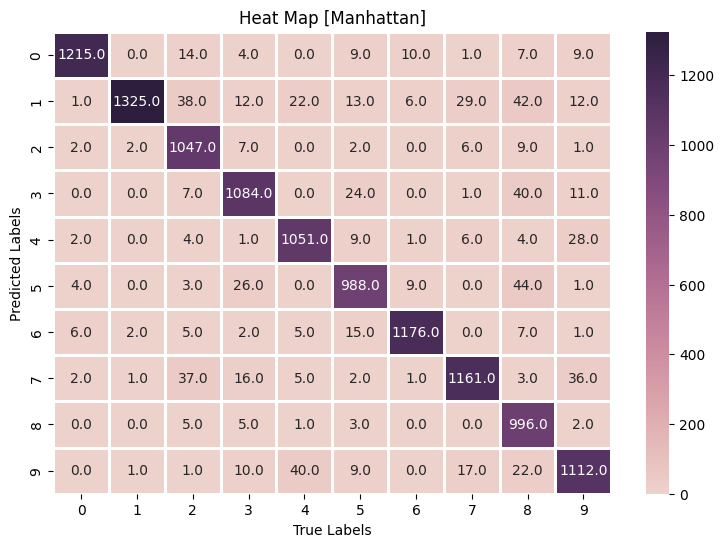

 
K-Fold Cross Validation for [k = 5] - [Euclidean] - [5 folds]
 
Accuracy [Euclidean]: 0.9460504201680672
 
Macro Average F1 [Euclidean] 0.9455556579780817
 
Confusion Matrix [Euclidean] [[1.213e+03 1.000e+00 1.500e+01 3.000e+00 0.000e+00 1.100e+01 1.100e+01
  1.000e+00 8.000e+00 9.000e+00]
 [1.000e+00 1.323e+03 2.200e+01 7.000e+00 1.500e+01 9.000e+00 6.000e+00
  2.400e+01 2.400e+01 7.000e+00]
 [4.000e+00 3.000e+00 1.070e+03 1.000e+01 0.000e+00 3.000e+00 0.000e+00
  4.000e+00 4.000e+00 1.000e+00]
 [1.000e+00 1.000e+00 5.000e+00 1.087e+03 0.000e+00 2.200e+01 0.000e+00
  1.000e+00 3.300e+01 9.000e+00]
 [1.000e+00 0.000e+00 5.000e+00 1.000e+00 1.062e+03 9.000e+00 1.000e+00
  5.000e+00 2.000e+00 2.200e+01]
 [3.000e+00 0.000e+00 1.000e+00 2.500e+01 0.000e+00 9.930e+02 7.000e+00
  0.000e+00 3.300e+01 1.000e+00]
 [7.000e+00 1.000e+00 6.000e+00 2.000e+00 4.000e+00 1.400e+01 1.176e+03
  0.000e+00 7.000e+00 1.000e+00]
 [2.000e+00 2.000e+00 2.900e+01 1.600e+01 4.000e+00 2.000e+00 1.000e+00
  1.1

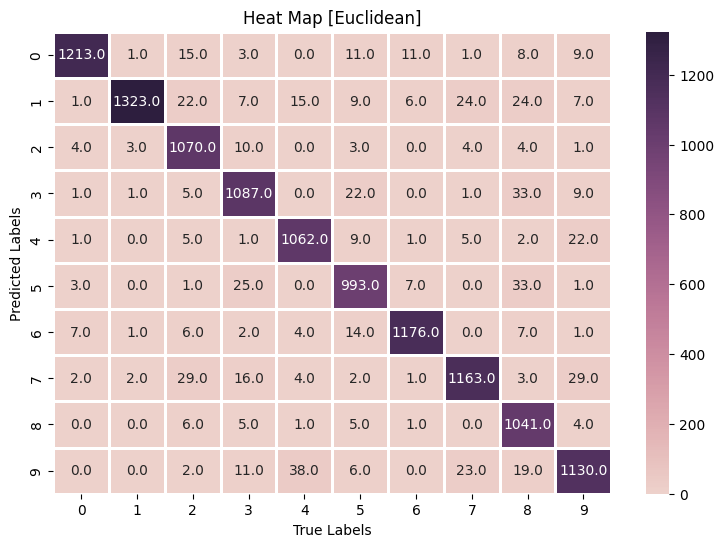

In [174]:
k = 5
num_of_folds = 5

print('K-Fold Cross Validation for [k = 5] - [Manhattan Distance] - [5 folds]')
print(" ")
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, manhattan_distance)
confusion_matrix_15, accuracy_15, macro_avg_f1_15 = evaluation(predicted_labels, labels_train)
print('Accuracy [Manhattan]:', accuracy_15)
print(" ")
print('Macro Average F1 [Manhattan]', macro_avg_f1_15)
print(" ")
print('Confusion Matrix [Manhattan]', confusion_matrix_15)
print(" ")
make_heat_map(confusion_matrix_15,'Heat Map [Manhattan]')
print(" ")
print('K-Fold Cross Validation for [k = 5] - [Euclidean] - [5 folds]')
print(" ")
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, euclidean_distance)
confusion_matrix_25, accuracy_25, macro_avg_f1_25 = evaluation(predicted_labels, labels_train)
print('Accuracy [Euclidean]:', accuracy_25)
print(" ")
print('Macro Average F1 [Euclidean]', macro_avg_f1_25)
print(" ")
print('Confusion Matrix [Euclidean]', confusion_matrix_25)
print(" ")
make_heat_map(confusion_matrix_25,'Heat Map [Euclidean]')

The graph below shows the, in total, five tested `k` values on the x-axis and classification accuracy on the y-axis for both the distance metrics.

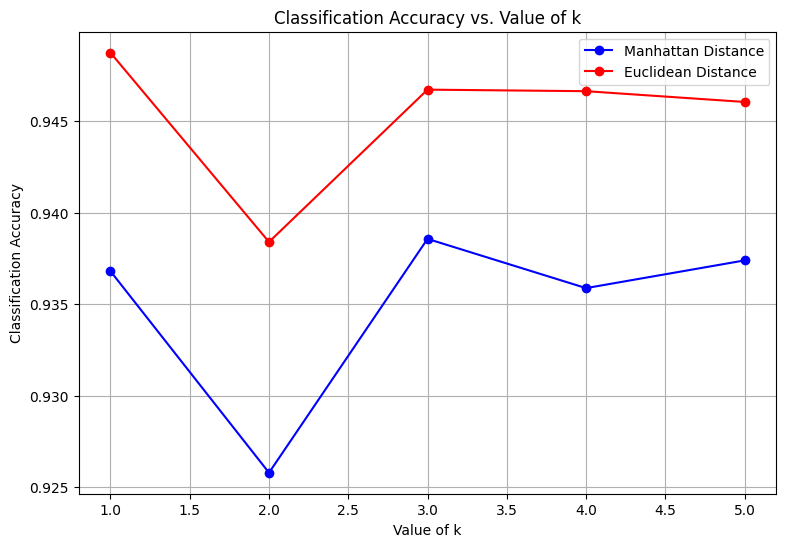

In [183]:
values_of_k = [1, 2, 3, 4, 5]
accuracies_manhattan = [accuracy_1, accuracy_12, accuracy_13, accuracy_14, accuracy_15] 
accuracies_euclidean = [accuracy_2, accuracy_22, accuracy_23, accuracy_24, accuracy_25]

plt.figure(figsize = (9, 6))
plt.plot(values_of_k, accuracies_manhattan, marker = 'o', linestyle = '-', color = 'b', label = 'Manhattan Distance')
plt.plot(values_of_k, accuracies_euclidean, marker = 'o', linestyle = '-', color = 'r', label = 'Euclidean Distance')
plt.title('Classification Accuracy vs. Value of k')
plt.xlabel('Value of k')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.legend() 
plt.show()

Next, I made a graph showcasing the values of `k` and their respective F1 scores for both the distance metrics.

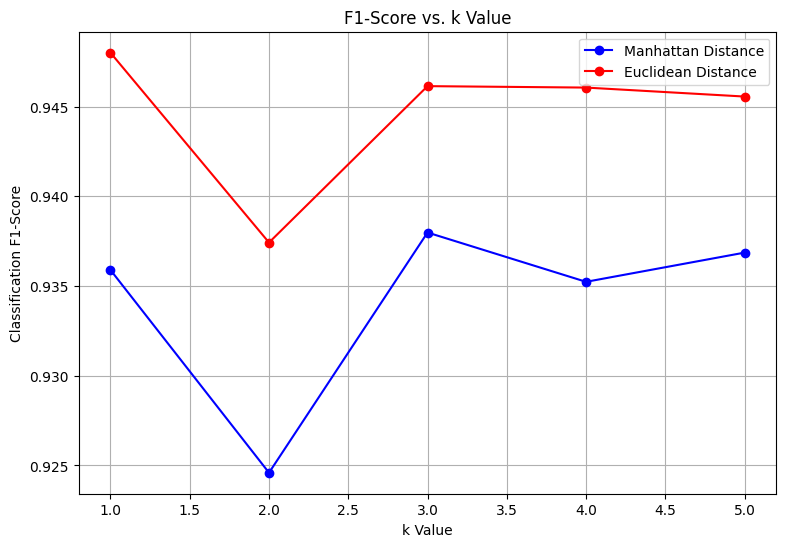

In [184]:
values_of_k = [1, 2, 3, 4, 5]
f1_scores_manhattan = [macro_avg_f1_1, macro_avg_f1_12, macro_avg_f1_13, macro_avg_f1_14, macro_avg_f1_15]
f1_scores_euclidean = [macro_avg_f1_2, macro_avg_f1_22, macro_avg_f1_23, macro_avg_f1_24, macro_avg_f1_25]

plt.figure(figsize = (9, 6))
plt.plot(values_of_k, f1_scores_manhattan, marker = 'o', linestyle = '-', color = 'b', label = 'Manhattan Distance')
plt.plot(values_of_k, f1_scores_euclidean, marker = 'o', linestyle = '-', color = 'r', label = 'Euclidean Distance')
plt.title('F1-Score vs. k Value')
plt.xlabel('k Value')
plt.ylabel('Classification F1-Score')
plt.grid(True)
plt.legend()
plt.show()

#### Comments:
From the cross validation results obtained for values of k ranging from 1 to 5, we can make a series of comments.
Smaller values of k (such as k = 1 or 2) seem to create decision boundaries that are highly influenced by individual data points. This can result in decision boundaries that are more complex and sensitive to noise in the data. Hence, such models are more prone to overfitting, meaning they may not generalize well to new, unseen data. 

On the other hand, larger values of k (such as k = 4 or 5) create decision boundaries that are relatively smoother and less sensitive to individual data points. But this maye result is an underfitted model. Hence, we can choose the value of k = 3, as it is a sort of balance between the two extremes mentioned earlier. Plus, it also has the highest accuracy as observed from the graphs obtained. 

### Implementing the K-NN classifier using Scikit-Learn (extra work)

Steps to follow along:
1. Performing 5-fold cross-validation and then running the K-NN classifier for values of `k = [1, 2, 3, 4, 5]` using both Euclidean and Manhattan distances.

2. Using scikit-learn's [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function to calculate the accuracy, the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to calculate macro-average F1 score,
and the [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function to calculate confusion matrix from the predicted labels. 

3. Finally, presenting the results as a graph with k values on the x-axis and performance measures on the y-axis as previously done. 



In [185]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

In [186]:
# Performing 5-fold cross-validation. 

# no need to reload the dataset sinch it is already loaded above
values_of_k = [1, 2, 3, 4, 5]
num_of_folds = 5

print('Distance Metrix = Euclidean Distance')
accuracy_euc = []
macroF1_euc = []
for k in values_of_k:
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean')
    predicted_labels = cross_val_predict(estimator = knn, X = features_train, y = labels_train, cv = num_of_folds)
    accuracy_euc.append(accuracy_score(labels_train, predicted_labels))
    macroF1_euc.append(classification_report(labels_train, predicted_labels, output_dict = True)['macro avg']['f1-score'])
    confusion = confusion_matrix(labels_train, predicted_labels)
    print("Euclidean Distance Accuracy for k =", k) 
    print("Accuracy: ", accuracy_euc[k - 1]) 
    print("MacroF1: ", macroF1_euc[k - 1])

print("\n")
print('Distance Metrix = Manhatten Distance')
accuracy_manh = []
macroF1_manh = []
for k in values_of_k:
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'manhattan')
    predicted_labels = cross_val_predict(estimator = knn, X = features_train, y = labels_train, cv = num_of_folds)
    accuracy_manh.append(accuracy_score(labels_train, predicted_labels))
    macroF1_manh.append(classification_report(labels_train, predicted_labels, output_dict = True)['macro avg']['f1-score'])
    confusion = confusion_matrix(labels_train, predicted_labels)
    print("Manhattan Distance Accuracy for k =", k) 
    print("Accuracy: ", accuracy_euc[k - 1])
    print("MacroF1: ", macroF1_euc[k - 1])

Distance Metrix = Euclidean Distance
Euclidean Distance Accuracy for k = 1
Accuracy:  0.9496638655462185
MacroF1:  0.9489520615409193
Euclidean Distance Accuracy for k = 2
Accuracy:  0.9389075630252101
MacroF1:  0.9379174322886781
Euclidean Distance Accuracy for k = 3
Accuracy:  0.9469747899159664
MacroF1:  0.9464259319774142
Euclidean Distance Accuracy for k = 4
Accuracy:  0.9457983193277311
MacroF1:  0.945205257965039
Euclidean Distance Accuracy for k = 5
Accuracy:  0.9459663865546218
MacroF1:  0.9454828389505938


Distance Metrix = Manhatten Distance
Manhattan Distance Accuracy for k = 1
Accuracy:  0.9496638655462185
MacroF1:  0.9489520615409193
Manhattan Distance Accuracy for k = 2
Accuracy:  0.9389075630252101
MacroF1:  0.9379174322886781
Manhattan Distance Accuracy for k = 3
Accuracy:  0.9469747899159664
MacroF1:  0.9464259319774142
Manhattan Distance Accuracy for k = 4
Accuracy:  0.9457983193277311
MacroF1:  0.945205257965039
Manhattan Distance Accuracy for k = 5
Accuracy:  0.94

Values of `k` vs `classification accuracies` :

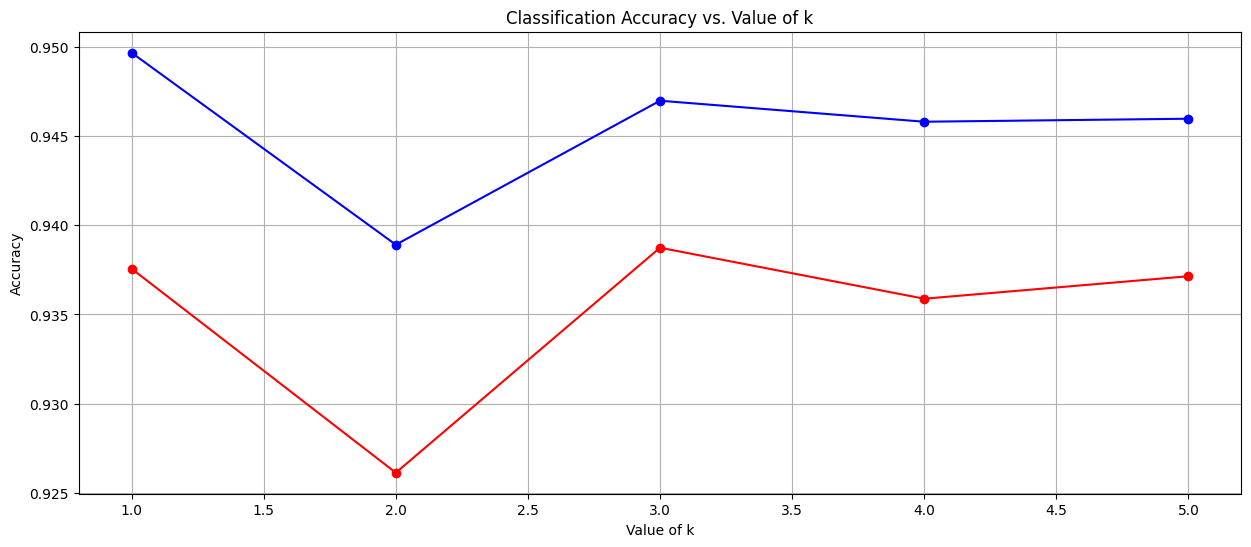

In [187]:
# Plotting a graph with k values on the x-axis and classifcation accuracy on the y-axis
k_values = [1, 2, 3, 4, 5]
plt.figure(figsize = (15, 6))
plt.plot(k_values, accuracy_euc, marker='o', linestyle = '-', color = 'b')
plt.plot(k_values, accuracy_manh, marker='o', linestyle = '-', color = 'r')
plt.title('Classification Accuracy vs. Value of k')
plt.xlabel('Value of k')
plt.ylabel('Accuracy')
plt.grid(True)

Values of `k` vs `F1-scores` :

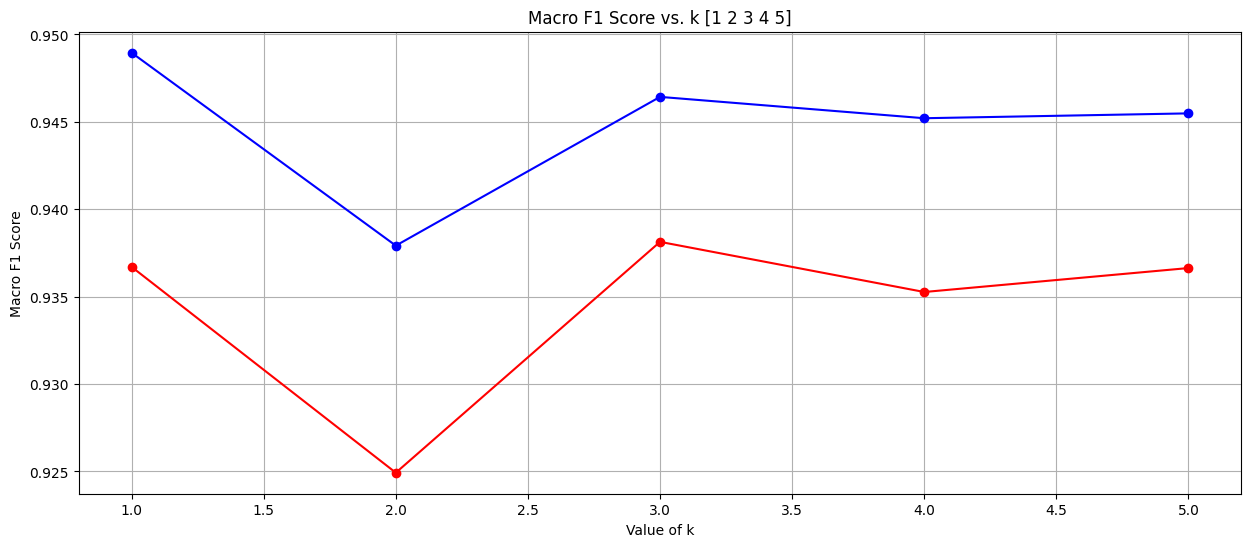

In [188]:
# Plotting a graph with k values on the x-axis and F1-score on the y-axis
k_values = [1, 2, 3, 4, 5]
plt.figure(figsize = (15, 6))
plt.plot(k_values, macroF1_euc, marker = 'o', linestyle = '-', color = 'b')
plt.plot(k_values, macroF1_manh, marker = 'o', linestyle = '-', color = 'r')
plt.title('Macro F1 Score vs. k [1 2 3 4 5]')
plt.xlabel('Value of k')
plt.ylabel('Macro F1 Score')
plt.grid(True)

Finished.